In [23]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import plotly.express as px
from itertools import product
import time
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Save Results

## Load mlflow runs

In [24]:
db_port = 5101
db_name = 'cohirf'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://beluccib@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
# results_dir = Path('~/tab_benchmark/results')
# os.makedirs(results_dir, exist_ok=True)

In [25]:
experiment_names

['Default',
 'classif_huge_cohirf',
 'classif_huge_kmeans',
 'classif_clusters_kmeans',
 'classif_clusters_cohirf',
 'classif_huge_cohirf_sampling',
 'classif_huge_cohirf_minibatch',
 'time_hc_CompleteAgglomerativeClustering_samples',
 'time_hc_WardAgglomerativeClustering_samples',
 'time_hc_OPTICS_samples',
 'time_hc_CompleteAgglomerativeClustering_features',
 'time_hc_Proclus_features',
 'time_hc_WardAgglomerativeClustering_features',
 'time_hc_KMeans_features',
 'time_hc_KMeansProj_samples',
 'time_hc_Clique_samples',
 'time_hc_DBSCAN_features',
 'time_hc_KMeans_samples',
 'time_hc_DBSCAN_samples',
 'time_hc_AffinityPropagation_samples',
 'time_hc_RecursiveClustering_features',
 'time_hc_SpectralSubspaceRandomization_samples',
 'time_hc_KMeansProj_features',
 'time_hc_MeanShift_features',
 'time_hc_HDBSCAN_features',
 'time_hc_OPTICS_features',
 'time_hc_Clique_features',
 'time_hc_IRFLLRR_features',
 'time_hc_RecursiveClustering_samples',
 'time_hc_MeanShift_samples',
 'time_hc_Spe

In [26]:
experiments_names = [exp for exp in experiment_names if exp.find('gaussian_random')!=-1]

In [27]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_centers',
    'distance',
    'pct_random_features',
    'seed_unified',
    'hpo_metric',
]

In [28]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity',
    'completeness',
    'v_measure',
    'silhouette',
    'calinski_harabasz_score',
    'davies_bouldin_score',
    'inertia_score',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
    'best_calinski_harabasz_score',
    'best_davies_bouldin_score',
    'best_inertia_score',
    'best_homogeneity',
    'best_completeness',
    'best_v_measure',
]

In [29]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [30]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [31]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [32]:
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [33]:
df_runs_raw_parents

key,status,start_time,end_time,distance,hpo_metric,model_nickname,n_centers,n_features,n_samples,pct_random_features,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
00165ba46a4d4649abaa29bfc4d0dfd8,FINISHED,1742945120954,1.742945e+12,10.0,silhouette,RecursiveClustering,5,10000,100,None,...,0.077049,18.0,0.035863,0.756160,-0.002213,0.035863,NaN,91e5aaa4b6a7406d99ef599c656f9f20,NaN,False
001da4bfa2d549d4bc10fcb4997f3ac4,FINISHED,1743016330176,1.743017e+12,30.0,silhouette,OPTICS,5,1000,1000,0.7,...,1.609438,5.0,1.000000,1.000000,0.162839,1.000000,NaN,81da8e9535444d46b60b25abcc63eb7e,NaN,False
0032db38711342899221559ff5ceed25,FINISHED,1742949219911,1.742950e+12,30.0,calinski_harabasz_score,RecursiveClustering,5,1000,10000,0.5,...,0.475268,11.0,0.259294,0.776188,-0.027034,0.259294,NaN,f6ed4db8c66244a1904cec975ac26d13,NaN,False
00376dfae41d44f790bcf03909ab771b,FINISHED,1743016472480,1.743017e+12,30.0,silhouette,RecursiveClustering_full,5,1000,1000,0.7,...,1.607984,37.0,0.754610,0.908686,0.021590,0.754610,NaN,07d23dd92b314e16bd1dc4a75b9fb66a,NaN,False
003beffb4a58404aa45a0a3849fafb3b,FINISHED,1742945120038,1.742945e+12,10.0,silhouette,RecursiveClustering,5,10000,100,None,...,0.009585,5.0,0.006628,0.587391,-0.000714,0.006628,NaN,cdf0a02fb4074da593d4c4df971ad251,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff25edd3c0984d93a57e7a6a1e5bb8ae,FINISHED,1743066115574,1.743066e+12,30.0,silhouette,DBSCAN,5,1000,1000,0.3,...,0.000000,1.0,0.000000,0.199840,-1.000000,0.000000,NaN,3be3a9e1e87f4d6c9af81ec602d7a0bb,NaN,False
ff270807cd854804997522e371f01a32,RUNNING,1742944831636,NaN,3.0,calinski_harabasz_score,RecursiveClustering,5,100,10000,None,...,0.070328,349.0,0.020224,0.796495,-0.125385,0.020224,NaN,NaN,NaN,NaN
ff537952c5cf4b2a871fb4b7005b5196,FINISHED,1742945329113,1.742945e+12,100.0,silhouette,RecursiveClustering,5,10000,100,None,...,1.046977,9.0,0.580898,0.851206,0.001599,0.580898,NaN,e38a4f5373b4487f85d1e4613a5b6584,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [34]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_centers',
    'distance',
    'seed_unified',
    'hpo_metric',
    'pct_random_features',
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]

# Missing

In [35]:
df_runs_parents['model_nickname'].unique().tolist()

['RecursiveClustering',
 'OPTICS',
 'RecursiveClustering_full',
 'AffinityPropagation',
 'AverageAgglomerativeClustering',
 'Clique',
 'KMeans',
 'MeanShift',
 'DBSCAN',
 'WardAgglomerativeClustering',
 'SpectralClustering',
 'Proclus',
 'CompleteAgglomerativeClustering',
 'HDBSCAN',
 'SingleAgglomerativeClustering',
 'KMeansProj',
 'SpectralSubspaceRandomization']

In [36]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'distance',
    'n_centers',
    'seed_unified',
    'hpo_metric',
    'pct_random_features',
]

In [37]:
n_samples = ['100', '1000']
n_features = ['100', '1000', '10000']
distances = ['3.0', '10.0', '30.0', '100.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'RecursiveClustering'
]
hpo_metric = ['silhouette']
pct_random_features = ['0.1', '0.3', '0.5', '0.7']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified, hpo_metric, pct_random_features]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [38]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified,hpo_metric,pct_random_features


In [39]:
n_samples = ['10000']
n_features = ['100', '1000', '10000']
distances = ['3.0', '10.0', '30.0', '100.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'RecursiveClustering'
]
hpo_metric = ['calinski_harabasz_score']
pct_random_features = ['0.1', '0.3', '0.5', '0.7']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified, hpo_metric, pct_random_features]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [40]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified,hpo_metric,pct_random_features
0,RecursiveClustering,10000,100,3.0,5,0,calinski_harabasz_score,0.1
1,RecursiveClustering,10000,100,3.0,5,0,calinski_harabasz_score,0.3
2,RecursiveClustering,10000,100,3.0,5,0,calinski_harabasz_score,0.5
3,RecursiveClustering,10000,100,3.0,5,0,calinski_harabasz_score,0.7
4,RecursiveClustering,10000,100,3.0,5,1,calinski_harabasz_score,0.3
...,...,...,...,...,...,...,...,...
86,RecursiveClustering,10000,10000,30.0,5,3,calinski_harabasz_score,0.5
87,RecursiveClustering,10000,10000,30.0,5,3,calinski_harabasz_score,0.7
88,RecursiveClustering,10000,10000,30.0,5,4,calinski_harabasz_score,0.1
89,RecursiveClustering,10000,10000,30.0,5,4,calinski_harabasz_score,0.7


In [41]:
n_samples = ['1000']
n_features = ['1000']
distances = ['30.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'AffinityPropagation',
    'AverageAgglomerativeClustering',
    'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    # 'IRFLLRR',
    'KMeans',
    # 'KMeansProj',
    'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'RecursiveClustering_full',
    'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    # 'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
hpo_metric = ['silhouette']
pct_random_features = ['0.1', '0.3', '0.5', '0.7']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified, hpo_metric, pct_random_features]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [42]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified,hpo_metric,pct_random_features


In [43]:
n_samples = ['100000']
n_features = ['10000']
distances = ['50.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'KMeans',
    'RecursiveClustering',
]
hpo_metric = ['calinski_harabasz_score']
pct_random_features = ['0.1', '0.3', '0.5', '0.7', '0.9']
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified, hpo_metric, pct_random_features]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [44]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified,hpo_metric,pct_random_features
0,KMeans,100000,10000,50.0,5,0,calinski_harabasz_score,0.1
1,KMeans,100000,10000,50.0,5,0,calinski_harabasz_score,0.3
2,KMeans,100000,10000,50.0,5,0,calinski_harabasz_score,0.5
3,KMeans,100000,10000,50.0,5,0,calinski_harabasz_score,0.7
4,KMeans,100000,10000,50.0,5,0,calinski_harabasz_score,0.9
5,KMeans,100000,10000,50.0,5,1,calinski_harabasz_score,0.1
6,KMeans,100000,10000,50.0,5,1,calinski_harabasz_score,0.3
7,KMeans,100000,10000,50.0,5,1,calinski_harabasz_score,0.5
8,KMeans,100000,10000,50.0,5,1,calinski_harabasz_score,0.7
9,KMeans,100000,10000,50.0,5,1,calinski_harabasz_score,0.9


In [24]:
# df = df_runs_raw.copy()
# df = df.loc[df['model_nickname'] == 'RecursiveClustering']
# df = df.loc[df['n_samples'] == '10000']
# df = df.loc[df['n_features'] == '1000']
# df = df.loc[df['n_centers'] == '5']
# df = df.loc[df['hpo_metric'] == 'calinski_harabasz_score']
# df = df.loc[df['pct_random_features'] == '0.7']
# df = df.loc[df['distance'] == '10.0']
# df

# Get common combinations

In [45]:
model_nickname = [
    'AffinityPropagation',
    'AverageAgglomerativeClustering',
    'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    # 'IRFLLRR',
    'KMeans',
    # 'KMeansProj',
    'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'RecursiveClustering_full',
    'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    # 'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
df = df_runs_parents.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = [
    'n_samples',
    'n_features',
    'distance',
    'n_centers',
    'seed_unified',
    'hpo_metric',
    'pct_random_features',
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [46]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [47]:
df_common['n_samples'] = df_common['n_samples'].astype(int)
df_common['n_features'] = df_common['n_features'].astype(int)
df_common['distance'] = df_common['distance'].astype(float)
df_common['n_centers'] = df_common['n_centers'].astype(float)
df_common['seed_unified'] = df_common['seed_unified'].astype(int)
df_common = df_common.loc[df_common['pct_random_features'] != 'None']
df_common['pct_random_features'] = df_common['pct_random_features'].astype(float)

In [48]:
df_common

key,status,start_time,end_time,distance,hpo_metric,model_nickname,n_centers,n_features,n_samples,pct_random_features,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
001da4bfa2d549d4bc10fcb4997f3ac4,FINISHED,1743016330176,1.743017e+12,30.0,silhouette,OPTICS,5.0,1000,1000,0.7,...,1.609438,5.0,1.000000,1.000000,0.162839,1.000000,NaN,81da8e9535444d46b60b25abcc63eb7e,NaN,False
00376dfae41d44f790bcf03909ab771b,FINISHED,1743016472480,1.743017e+12,30.0,silhouette,RecursiveClustering_full,5.0,1000,1000,0.7,...,1.607984,37.0,0.754610,0.908686,0.021590,0.754610,NaN,07d23dd92b314e16bd1dc4a75b9fb66a,NaN,False
01c35bb5752945a6a6a45be98fcc7799,FINISHED,1743067066850,1.743068e+12,30.0,silhouette,AffinityPropagation,5.0,1000,1000,0.5,...,1.609438,60.0,0.583568,0.824905,-0.006408,0.583568,NaN,fa158b3f6ae14e44bf9135ae4fd9748e,NaN,False
01e28d507b914965a2b6ac9de6fd2be4,FINISHED,1743014611271,1.743015e+12,30.0,silhouette,AverageAgglomerativeClustering,5.0,1000,1000,0.3,...,1.609438,14.0,0.995598,0.999281,0.112145,0.995598,NaN,2b9c5968b0624e148630519bc980acea,NaN,False
0336ad80fc7b496bad727d4e8614c38e,FINISHED,1743066073399,1.743069e+12,30.0,silhouette,Clique,5.0,1000,1000,0.1,...,0.000000,1.0,0.000000,0.199840,-1.000000,0.000000,NaN,3364a41879dc4b498562bd36b6892e99,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f866b073edd8438daee886a3b8d83332,FINISHED,1743066043135,1.743067e+12,30.0,silhouette,SingleAgglomerativeClustering,5.0,1000,1000,0.3,...,1.609438,14.0,0.995598,0.999281,0.164167,0.995598,NaN,8c5e261adaa34a9fb17b769d2f2b0784,NaN,False
fa17f70227c34a4592b14193e20c34c0,FINISHED,1743066155059,1.743067e+12,30.0,silhouette,Proclus,5.0,1000,1000,0.3,...,0.155988,14.0,0.081061,0.727086,-0.055119,0.081061,NaN,239474f76be2450bb49b1dcc83841d93,NaN,False
fb39bf3fdd254f23a90c341f250bd5e3,FINISHED,1743066077309,1.743069e+12,30.0,silhouette,Clique,5.0,1000,1000,0.3,...,0.000000,1.0,0.000000,0.199840,-1.000000,0.000000,NaN,e6e3e15feafd4c5ab5ac9c406a720b3f,NaN,False


# Plots

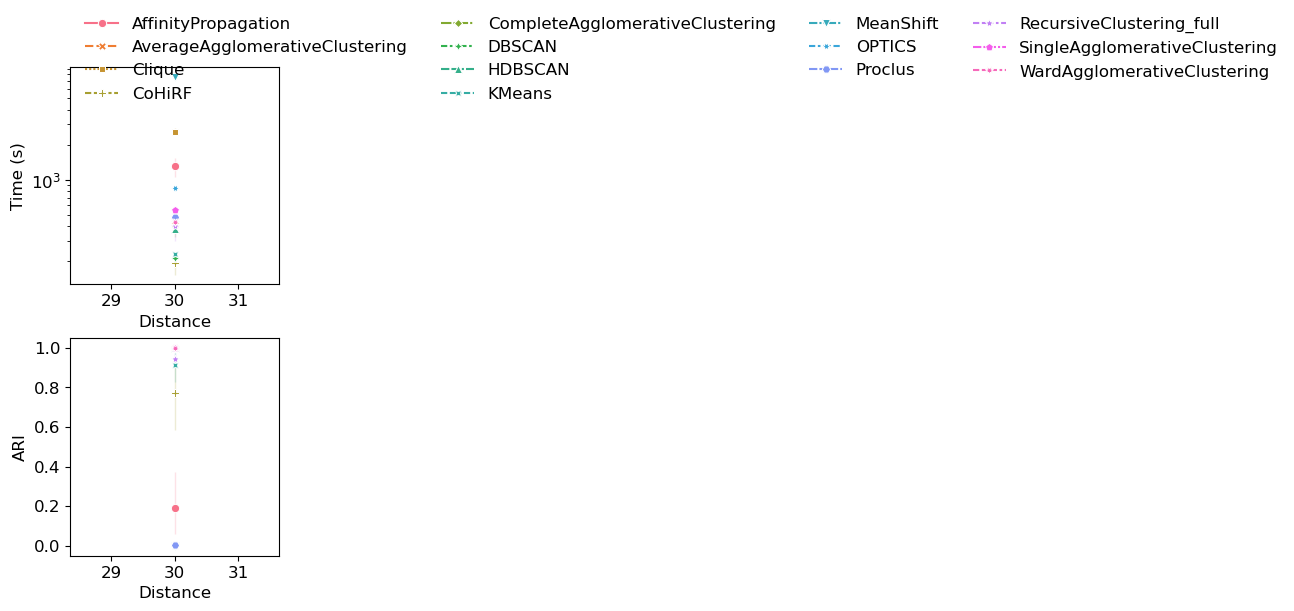

In [49]:
df = df_common.copy()
n_features = 1000
n_samples = 1000
pct_random_features = 0.1
distance = 30
models_names = {
    'RecursiveClustering': 'CoHiRF',
}
df = df.loc[df['pct_random_features']==pct_random_features]
# df = df.loc[df['distance']==distance]
# df = df.loc[~df['class_sep'].isin([10, 20])]
# df = df.loc[df['model_nickname'].isin(['RecursiveClustering_20', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'distance': 'Distance', 'pct_random_features': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Distance', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[0])
    ax.legend().set_visible(False)
    ax.set_yscale('log')
    ax2 = sns.lineplot(data=df_plot, x='Distance', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[1])
    ax2.legend().set_visible(False)
    ax.legend(title=None, fontsize=12, bbox_to_anchor=(0.0, 1.3), ncols=4)
    # plt.savefig(results_dir / f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}_with_time.pdf')
    plt.show()

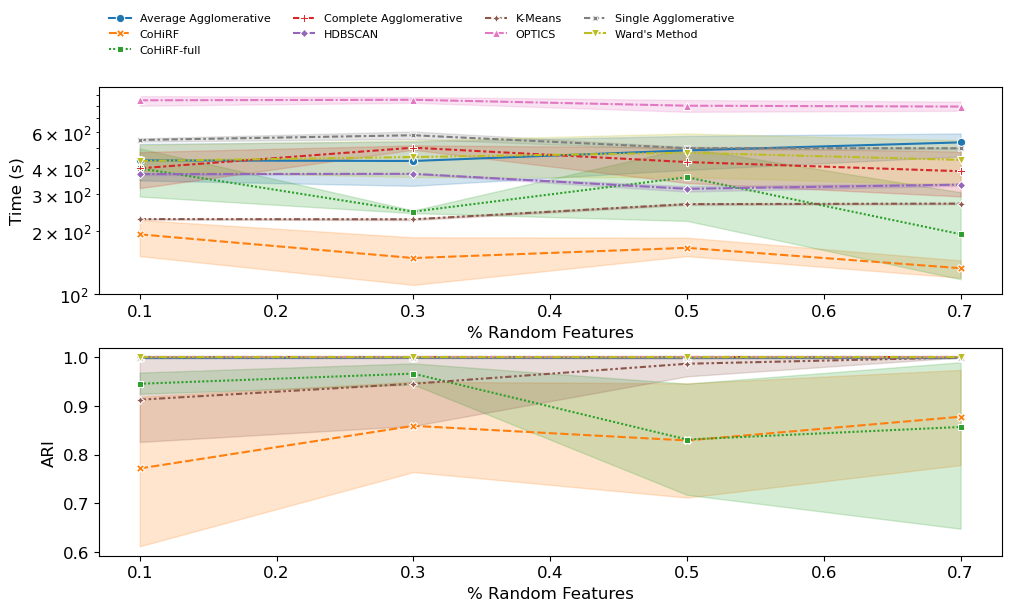

In [50]:
df = df_common.copy()
n_features = 1000
n_samples = 1000
pct_random_features = 0.1
distance = 30
models_names = {
    'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_full': 'CoHiRF-full',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    # 'DBSCAN': 'DBSCAN',
    # 'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
    'AverageAgglomerativeClustering': 'Average Agglomerative',
    'CompleteAgglomerativeClustering': 'Complete Agglomerative',
    'SingleAgglomerativeClustering': 'Single Agglomerative',
    'IRFLLRR': 'IRFLLRR',
    # 'Proclus': 'Proclus',
    # 'Clique': 'Clique',
    'KMeansProj': 'Projective K-Means',
}
# df = df.loc[df['pct_random_features']==pct_random_features]
df = df.loc[df['distance']==distance]
# df = df.loc[~df['class_sep'].isin([10, 20])]
df = df.loc[df['model_nickname'].isin(models_names.keys())]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'distance': 'Distance', 'pct_random_features': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    ax = sns.lineplot(data=df_plot, x='% Random Features', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[0])
    ax.legend().set_visible(False)
    ax.set_yscale('log')
    ax2 = sns.lineplot(data=df_plot, x='% Random Features', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[1])
    ax2.legend().set_visible(False)
    ax.legend(title=None, fontsize=8, bbox_to_anchor=(0.0, 1.4), ncols=4)
    # plt.savefig(results_dir / f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}_with_time.pdf')
    plt.show()

# Debug and explore

In [61]:
df = df_runs_raw_parents.copy()
df = df.loc[df['model_nickname'] == 'SpectralClustering']
df = df.loc[df['n_samples'] == '10000']
df = df.loc[df['n_features'] == '100']
df = df.loc[df['best_adjusted_rand'].isna()]

In [62]:
df

key,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
030506f367eb4de3ba20854815b5204e,RUNNING,1736933684597,NaN,50.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0a9621d4c0b94f71b8b3381c6fb5c007,RUNNING,1736933682412,NaN,50.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4283d0ec6c2a44609380a30ba9ad84b7,RUNNING,1736933676990,NaN,100.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86f54c66e3a24ae3abd719993b9e8e8f,RUNNING,1736933680295,NaN,10.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d40e99f19313471b849c6a89d5714ec3,RUNNING,1736933677012,NaN,10.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f2472d2177ee4224888a3f9221aa27f8,RUNNING,1736933676833,NaN,100.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
parent_run_ids = list(df.index)

In [39]:
parent_run_ids

['19a02df7b5aa4cf7afa3bd89746701e6',
 '49cd3a57c8c445888338d601be88e165',
 '4ca1b086e9d54eb69b43c9d2a9f61751',
 '8ebecbdcf2534dbdb37fab56eb920877',
 'bc25dc49e69644d9b4ea7d47831c0db5',
 'c08e53cf4d534e67904e72ae35794d0e']

In [40]:
df = df_runs_raw.copy()
df = df.loc[df['parent_run_id'].isin(parent_run_ids)]

In [41]:
child_run_ids = list(df.index)

In [42]:
runs_to_delete = parent_run_ids + child_run_ids

In [43]:
runs_to_delete

['19a02df7b5aa4cf7afa3bd89746701e6',
 '49cd3a57c8c445888338d601be88e165',
 '4ca1b086e9d54eb69b43c9d2a9f61751',
 '8ebecbdcf2534dbdb37fab56eb920877',
 'bc25dc49e69644d9b4ea7d47831c0db5',
 'c08e53cf4d534e67904e72ae35794d0e',
 '1d4c759e165b4267af1d71e2dadb662e',
 '4731af3b49f94df79ed9c06cb61e5da9',
 '667f300899fe4b998d839e3958dedbd0',
 '8f9e6a95c8bd4f838fcb3085a3927482',
 'c7b04bdc92654f8da5f28f7a0474de79',
 'e97b7dd9f4c94acb95ad1b389c91aa3d']

In [44]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [45]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    